# Street sign with Pre-Trained WideResNet

With additional shield net

* case study, evaluate one model 


In [1]:
from torch.utils.data import Dataset, DataLoader
from os.path import join
import pandas as pd 
from PIL import Image
from torch.optim import SGD
import seaborn as sb 
from gtsrb import GTSRB
from detectors import EnsembleDetector, SemanticDetector
sb.set()

import os
os.environ['CUDA_VISIBLE_DEVICES'] = "MIG-GPU-8ab9a0c8-909c-3f13-97e6-7376d6d4a029/0/0"


device="cuda:0"
root = "data/"

import torch
torch.manual_seed(0)

import numpy as np
np.random.seed(0)

import random
random.seed(0)

torch.use_deterministic_algorithms(False)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)


In [2]:
import torchvision
from torchvision.transforms import ToTensor, Resize, Compose
import torch 
from torch.utils.data import DataLoader

trans = Compose([ToTensor(), Resize((32, 32))])

train_data = GTSRB(root=root, train=True, transforms=trans)
test_data = GTSRB(root=root, train=False, transforms=trans)

In [3]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2, worker_init_fn=seed_worker)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=2, worker_init_fn=seed_worker)

In [4]:
from torch import nn
from torchvision.models.resnet import resnet18
from pytorch_ood.model import WideResNet

# def override 
def Model(num_classes=None, *args, **kwargs):
    model = WideResNet(*args, num_classes=1000, **kwargs, pretrained="imagenet32")
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model


In [5]:
from tqdm.notebook import tqdm 
import numpy as np 

def train_model(att_index, num_classes):
    """
    train a model for the given attribute index 
    """
    trans = Compose([ToTensor(), Resize((32, 32))])
    train_data = GTSRB(root=root, train=True, transforms=trans)
    test_data = GTSRB(root=root, train=False, transforms=trans)
    
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2, worker_init_fn=seed_worker)
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=2, worker_init_fn=seed_worker)
    
    model = Model(num_classes=num_classes).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True)

    accs = []

    for epoch in range(20):
        running_loss = 0.0
        model.train()
        bar = tqdm(train_loader)
        for inputs, y in bar:
            labels = y[:, att_index]
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss = 0.8 * running_loss + 0.2 * loss.item()
            bar.set_postfix({"loss": running_loss})

        correct = 0
        total = 0

        with torch.no_grad():
            model.eval()

            for inputs, y in test_loader:
                labels = y[:, att_index]
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, dim=1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f'Accuracy of the network on the test images: {correct / total:.2%}')

    return model 

# Sign Network 

In [6]:
from torch.utils.data import DataLoader
from pytorch_ood.utils import is_known
from tqdm.notebook import tqdm 
from pytorch_ood.dataset.img import TinyImages300k
from pytorch_ood.utils import ToUnknown
from torch.utils.data import random_split

def train_sign_model():
    tiny = TinyImages300k(root=root, download=True, transform=trans, target_transform=ToUnknown())
    data_train_out, data_test_out, _ = random_split(tiny, [50000, 10000, 240000], generator=torch.Generator().manual_seed(123))

    train_data_noatt = GTSRB(root=root, train=True, transforms=trans, target_transform=lambda y: y[0])
    test_data_noatt = GTSRB(root=root, train=False, transforms=trans, target_transform=lambda y: y[0])

    new_loader = DataLoader(train_data_noatt + data_train_out, batch_size=32, shuffle=True, num_workers=10, worker_init_fn=seed_worker)
    new_test_loader = DataLoader(test_data_noatt + data_test_out, batch_size=32, shuffle=False, num_workers=10, worker_init_fn=seed_worker)

    model = Model(num_classes=2).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True)

    accs = []

    for epoch in range(20):
        running_loss = 0.0
        model.train()
        
        bar = tqdm(new_loader)
        for inputs, y in bar:
            labels = is_known(y).long()
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss = 0.8 * running_loss + 0.2 * loss.item()
            bar.set_postfix({"loss": running_loss})

        correct = 0
        total = 0

        with torch.no_grad():
            model.eval()

            for inputs, y in new_test_loader:
                labels = is_known(y).long()
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f'Accuracy of the shape network on the test images: {correct / total:.2%}')
        accs.append(correct / total)

    return model 

# OOD Evaluation 

In [7]:
from pytorch_ood.dataset.img import (LSUNCrop, LSUNResize, Textures, TinyImageNetCrop, TinyImageNetResize)
from pytorch_ood.detector import EnergyBased, MaxSoftmax
from pytorch_ood.utils import ToRGB, OODMetrics

def evaluate(label_net, shape_net, color_net, shield_net):
    _ = label_net.eval()
    _ = shape_net.eval()
    _ = color_net.eval()
    _ = shield_net.eval()
    
    results = []

    trans = Compose([Resize(size=(32, 32)), ToRGB(), ToTensor()])
    data_in = GTSRB(root=root, train=False, transforms=trans, target_transform=lambda y: y[0])
    # dataset_out_test = Textures(root=root, transform=trans, target_transform=ToUnknown(), download=True)
    
    
    detectors = {
        "MSP": MaxSoftmax(label_net),
        "Energy": EnergyBased(label_net),
        "Semantic-OE": SemanticDetector(
            label_net, 
            shape_net, 
            color_net, 
            GTSRB(root=root).class_to_shape, 
            GTSRB(root=root).class_to_color, 
            sign_net=shield_net
        ),
        "Semantic": SemanticDetector(
                label_net, 
                shape_net, 
                color_net, 
                GTSRB(root=root).class_to_shape, 
                GTSRB(root=root).class_to_color, 
        ),
        "Ensemble": EnsembleDetector(label_net, shape_net, color_net)
    }
    
    datasets = {d.__name__: d for d in (LSUNCrop, LSUNResize, Textures, TinyImageNetCrop, TinyImageNetResize)}
    
    for detector_name, detector in detectors.items():
        for data_name, dataset_c in datasets.items():
            data_out = dataset_c(root=root, transform=trans, target_transform=ToUnknown(), download=True)
            loader = DataLoader(data_in+data_out, batch_size=1024, shuffle=False, worker_init_fn=seed_worker)
            
            scores = []
            ys = []
            
            with torch.no_grad():
                for x, y in loader:
                    scores.append(detector(x.to(device)))
                    ys.append(y.to(device))
                    
                scores = torch.cat(scores, dim=0).cpu()
                ys = torch.cat(ys, dim=0).cpu()
            
            metrics = OODMetrics()
            metrics.update(scores, ys)
            r = metrics.compute()
            r.update({
                "Method": detector_name,
                "Dataset": data_name
            })
            print(r)
            results.append(r)
    
    return results 

In [8]:
def evaluate_acc(net, att_idx=0, oe=False):
    _ = net.eval()
    
    if oe:
        target_trans = lambda y: torch.tensor(1)
    else:
         target_trans = lambda y: y[att_idx]

    trans = Compose([Resize(size=(32, 32)), ToRGB(), ToTensor()])
    data_in = GTSRB(root=root, train=False, transforms=trans, target_transform=target_trans)
    loader = DataLoader(data_in, batch_size=1024, shuffle=False, worker_init_fn=seed_worker)
            
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            predicted = outputs.max(dim=1).indices
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return correct / total  

def evaluate_accs(label_net, shape_net, color_net, shield_net):
    r = {}
    names = ("Label", "Color", "Shape",)
    
    for n, net in enumerate((label_net, color_net, shape_net)): 
        acc = evaluate_acc(net, n)
        r[names[n]] = acc
    
    acc = evaluate_acc(shield_net, oe=True)
    r["Sign"] = acc
    
    return [r] 

In [9]:
results = []
results_acc = []

for trial in range(1):
    shield_net = train_sign_model()
    shape_net = train_model(att_index=2, num_classes=5)
    color_net = train_model(att_index=1, num_classes=4)
    label_net = train_model(att_index=0, num_classes=43)
    
    res = evaluate(label_net, shape_net, color_net, shield_net)
    res_acc = evaluate_accs(label_net, shape_net, color_net, shield_net)
    
    for r in res:
        r.update({"Seed": trial})
        
    for r in res_acc:
        r.update({"Seed": trial})
    
    results += res
    results_acc += res_acc

  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.89%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.97%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.95%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.99%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.98%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.98%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.98%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.97%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 100.00%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.98%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.94%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.99%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.98%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.97%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.99%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.95%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.93%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.97%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.99%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.96%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.94%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.96%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.99%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.97%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.97%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.91%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.97%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.97%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.97%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.96%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.97%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.97%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.97%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.97%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.97%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.97%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.81%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.90%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.79%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.94%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.93%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.96%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 100.00%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.97%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 100.00%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 100.00%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 100.00%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 100.00%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.99%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 100.00%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 100.00%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 97.47%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.42%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.53%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.94%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.60%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.67%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.18%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.19%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.58%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.00%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.09%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.82%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.92%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.13%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.17%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.04%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.18%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.02%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.18%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.11%
{'AUROC': 0.9902477264404297, 'AUPR-IN': 0.9847794771194458, 'AUPR-OUT': 0.9930233359336853, 'ACC95TPR': 0.9593018293380737, 'FPR95TPR': 0.03333333507180214, 'Method': 'MSP', 'Dataset': 'LSUNCrop'}
{'AUROC': 0.9963264465332031, 'AUPR-IN': 0.9939179420471191, 'AUPR-OUT': 0.9976773262023926, 'ACC95TPR': 0.9706584215164185, 'FPR95TPR': 0.012984956614673138, 'Method': 'MSP', 'Dataset': 'LSUNResize'}
{'AUROC': 0.9883217215538025, 'AUPR-IN': 0.9754612445831299, 'AUPR-OUT': 0.9919120073318481, 'ACC95TPR': 0.9671045541763306, 'FPR95TPR': 0.025257322937250137, 'Method': 'MSP', 'Dataset': 'Textures'}
{'AUROC': 0.9934267997741699, 'AUPR-IN': 0.9901189804077148, 'AUPR-OUT': 0.9950511455535889, 'ACC95TPR': 0.9662395119667053, 'FPR95TPR': 0.020902613177895546, 'Method': 'MSP', 'Dataset': 'TinyImageNetCrop'}
{'AUROC': 0.9942823052406311, 'AUPR-IN': 0.9911289215087891, 'AUPR-OUT': 0.9957008361816406, 'ACC95TPR': 0.9687582850456238, 'FPR95TPR': 0.01638

In [10]:
import pandas as pd 
result_df = pd.DataFrame(results)
print((result_df.groupby(by="Method").agg(["mean", "sem"]) * 100)[["AUROC", "AUPR-IN", "AUPR-OUT", "FPR95TPR"]].to_latex(float_format="%.2f"))

\begin{tabular}{lrrrrrrrr}
\toprule
{} & \multicolumn{2}{l}{AUROC} & \multicolumn{2}{l}{AUPR-IN} & \multicolumn{2}{l}{AUPR-OUT} & \multicolumn{2}{l}{FPR95TPR} \\
{} &  mean &  sem &    mean &  sem &     mean &  sem &     mean &  sem \\
Method      &       &      &         &      &          &      &          &      \\
\midrule
Energy      & 99.32 & 0.24 &   99.08 & 0.35 &    99.41 & 0.20 &     1.73 & 0.52 \\
Ensemble    & 99.79 & 0.02 &   99.63 & 0.10 &    99.88 & 0.01 &     0.88 & 0.04 \\
MSP         & 99.25 & 0.14 &   98.71 & 0.33 &    99.47 & 0.10 &     2.18 & 0.36 \\
Semantic    & 99.85 & 0.01 &   99.75 & 0.05 &    99.92 & 0.00 &     0.68 & 0.07 \\
Semantic-OE & 99.95 & 0.00 &   99.92 & 0.01 &    99.98 & 0.00 &     0.10 & 0.00 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_2438319/2493558079.py:3: FutureWarning: ['Dataset'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  print((result_df.groupby(by="Method").agg(["mean", "sem"]) * 100)[["AUROC", "AUPR-IN", "AUPR-OUT", "FPR95TPR"]].to_latex(float_format="%.2f"))
/tmp/ipykernel_2438319/2493558079.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print((result_df.groupby(by="Method").agg(["mean", "sem"]) * 100)[["AUROC", "AUPR-IN", "AUPR-OUT", "FPR95TPR"]].to_latex(float_format="%.2f"))


In [11]:
from scipy.stats import ttest_ind

sem_auroc = result_df[result_df["Method"] == "Semantic"].groupby(by=["Method", "Seed"]).mean()["AUROC"]
sem_ensemble =  result_df[result_df["Method"] == "Ensemble"].groupby(by=["Method", "Seed"]).mean()["AUROC"]

print(ttest_ind(sem_auroc, sem_ensemble, equal_var=False))

Ttest_indResult(statistic=nan, pvalue=nan)


/tmp/ipykernel_2438319/299598497.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sem_auroc = result_df[result_df["Method"] == "Semantic"].groupby(by=["Method", "Seed"]).mean()["AUROC"]
/tmp/ipykernel_2438319/299598497.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sem_ensemble =  result_df[result_df["Method"] == "Ensemble"].groupby(by=["Method", "Seed"]).mean()["AUROC"]
/tmp/ipykernel_2438319/299598497.py:6: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  print(ttest_ind(sem_

In [12]:
print((pd.DataFrame(results_acc) * 100).agg(["mean", "sem"]).to_latex(float_format="%.2f"))

\begin{tabular}{lrrrrr}
\toprule
{} &  Label &  Color &  Shape &  Sign &  Seed \\
\midrule
mean &  99.18 & 100.00 &  99.97 & 99.99 &  0.00 \\
sem  &    NaN &    NaN &    NaN &   NaN &   NaN \\
\bottomrule
\end{tabular}



/tmp/ipykernel_2438319/3946649051.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print((pd.DataFrame(results_acc) * 100).agg(["mean", "sem"]).to_latex(float_format="%.2f"))


In [13]:
(result_df.groupby(by=["Method", "Seed"]).mean() * 100).groupby("Method").agg(["mean", "sem"])

/tmp/ipykernel_2438319/735313046.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  (result_df.groupby(by=["Method", "Seed"]).mean() * 100).groupby("Method").agg(["mean", "sem"])


AUROC        AUPR-IN       AUPR-OUT       ACC95TPR      \
                  mean sem       mean sem       mean sem       mean sem   
Method                                                                    
Energy       99.315373 NaN  99.079436 NaN  99.411247 NaN  96.892296 NaN   
Ensemble     99.792286 NaN  99.631342 NaN  99.875978 NaN  97.403375 NaN   
MSP          99.252100 NaN  98.708131 NaN  99.467293 NaN  96.641252 NaN   
Semantic     99.853210 NaN  99.747697 NaN  99.916075 NaN  97.522525 NaN   
Semantic-OE  99.948193 NaN  99.923408 NaN  99.978423 NaN  99.899700 NaN   

             FPR95TPR      
                 mean sem  
Method                     
Energy       1.733967 NaN  
Ensemble     0.883610 NaN  
MSP          2.177356 NaN  
Semantic     0.676168 NaN  
Semantic-OE  0.102930 NaN

In [14]:
pd.DataFrame(results_acc).agg(["mean", "sem"])
# dataset gives np.array([label, color, shape])

# results_acc = evaluate_accs(label_net, shape_net, color_net, shield_net)
# print(results_acc)

,Label,Color,Shape,Sign,Seed
mean,0.991845,1.0,0.999683,0.999921,0.0
sem,NaN,NaN,NaN,NaN,NaN


# Eval

In [15]:
def ood_label(x):
    if x == True:
        return "Normal"
    else:
        return "Anomaly"

In [16]:
trans = Compose([Resize(size=(32, 32)), ToRGB(), ToTensor()])

In [17]:
from pytorch_ood.utils import OODMetrics, ToRGB, ToUnknown
from pytorch_ood.dataset.img import Textures

In [18]:
test_in_data = GTSRB(root=root, train=False, transforms=trans, target_transform=lambda y: y[0])
dataset_out_test = Textures(root=root, transform=trans, target_transform=ToUnknown(), download=True)
loader = DataLoader(dataset_out_test +  test_in_data, batch_size=128, worker_init_fn=seed_worker)

sem_detector = SemanticDetector(
            label_net, 
            shape_net, 
            color_net, 
            GTSRB(root=root).class_to_shape, 
            GTSRB(root=root).class_to_color, 
            sign_net=shield_net
        )

with torch.no_grad():
    metrics = OODMetrics()
    for x, y in tqdm(loader):
        metrics.update(sem_detector(x.to(device)), y.to(device))

print(metrics.compute())

  0%|          | 0/143 [00:00<?, ?it/s]

{'AUROC': 0.13750888407230377, 'AUPR-IN': 0.5647227168083191, 'AUPR-OUT': 0.9998371005058289, 'ACC95TPR': 0.998741090297699, 'FPR95TPR': 0.0010292953811585903}


In [19]:
with torch.no_grad():
    metrics = OODMetrics()
    for x, y in tqdm(loader):
        metrics.update(-shield_net(x.to(device)).softmax(dim=1)[:,1].cpu(), y.to(device))

sign_net_metric = metrics.compute()
print(sign_net_metric)

  0%|          | 0/143 [00:00<?, ?it/s]

{'AUROC': 0.9999062418937683, 'AUPR-IN': 0.9999278783798218, 'AUPR-OUT': 0.9999549388885498, 'ACC95TPR': 0.9845648407936096, 'FPR95TPR': 0.0}


In [49]:
from tqdm.notebook import tqdm 
test_in_data = GTSRB(root=root, train=False, transforms=trans, target_transform=lambda y: y[0])

sem_detector = SemanticDetector(
    label_net, 
    shape_net, 
    color_net, 
    GTSRB(root=root).class_to_shape, 
    GTSRB(root=root).class_to_color, 
    sign_net=shield_net
)

scores = []
my_scores = []
ys = []
xs = []
ys_hat = []

metrics = OODMetrics()

datasets = (LSUNCrop, LSUNResize, Textures, TinyImageNetCrop, TinyImageNetResize)
datasets = [c(root=root, transform=trans, target_transform=ToUnknown(), download=True) for c in datasets]
loaders = [DataLoader(d, batch_size=128, worker_init_fn=seed_worker) for d in datasets]
loaders.append( DataLoader(test_in_data, batch_size=128, worker_init_fn=seed_worker))

with torch.no_grad():
     for loader in loaders:
        for x, y in tqdm(loader):
            x = x.to(device)
            scores.append(detector(x))
            ys_hat.append(label_net(x).softmax(dim=1).max(dim=1).indices) 
            my_scores.append(sem_detector(x))

            ys.append(y)
            xs.append(x.cpu())


scores = torch.cat(scores, dim=0).cpu()
ys = torch.cat(ys, dim=0).cpu()
ys_hat = torch.cat(ys_hat, dim=0).cpu()
my_scores = torch.cat(my_scores, dim=0).cpu()
xs = torch.cat(xs, dim=0).cpu()


metrics = OODMetrics()
metrics.update(my_scores, ys)
print(metrics.compute())

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

{'AUROC': 0.9994824528694153, 'AUPR-IN': 0.9998566508293152, 'AUPR-OUT': 0.9995864629745483, 'ACC95TPR': 0.9990389347076416, 'FPR95TPR': 0.0010292953811585903}


In [50]:
scores

tensor([-1.9247, -2.3903, -2.8967,  ..., -2.9974, -2.9999, -3.0000])

In [51]:
y

tensor([ 2, 38, 24, 25,  9,  5,  1, 22,  5,  7,  6, 12, 16,  3, 35,  1,  9,  7,
         8, 30, 23,  2, 39, 23, 10, 11,  1,  2, 15, 17,  7,  2, 18, 11,  9, 20,
         2,  9,  3,  1, 11,  8, 10,  6, 10,  3, 25,  5, 22,  3, 12, 25, 13, 10,
        35, 10, 35, 38, 24, 13, 35, 25, 38,  1, 18,  7, 35, 11, 39,  8,  0, 10,
        18, 31,  8, 31, 13,  5, 12, 35, 25, 12, 33,  6,  7, 10])

In [52]:
from pytorch_ood.utils import is_unknown


print(xs.shape)
print(my_scores.shape)
print(ys_hat.shape)
print(ys.shape)
print(scores.shape)

print(is_known(ys).sum())
print(is_unknown(ys).sum())


torch.Size([58270, 3, 32, 32])
torch.Size([58270])
torch.Size([58270])
torch.Size([58270])
torch.Size([58270])
tensor(12630)
tensor(45640)


<AxesSubplot: xlabel='Scores', ylabel='Probability'>

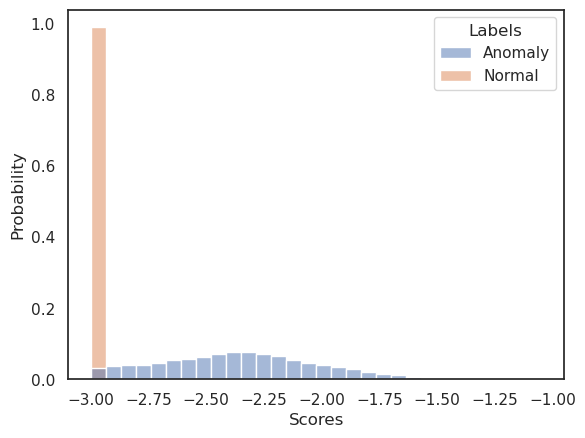

In [53]:
from pandas import DataFrame

df_1 = DataFrame()
df_1["Scores"] = scores.cpu().numpy()
df_1["Labels"] = ys >= 0
df_1["Labels"] = df_1["Labels"].apply(ood_label)
df_1["Method"] = "Implicit"

sb.histplot(data=df_1, x="Scores", hue="Labels", common_norm=False, stat="probability", bins=30)

# Examples 

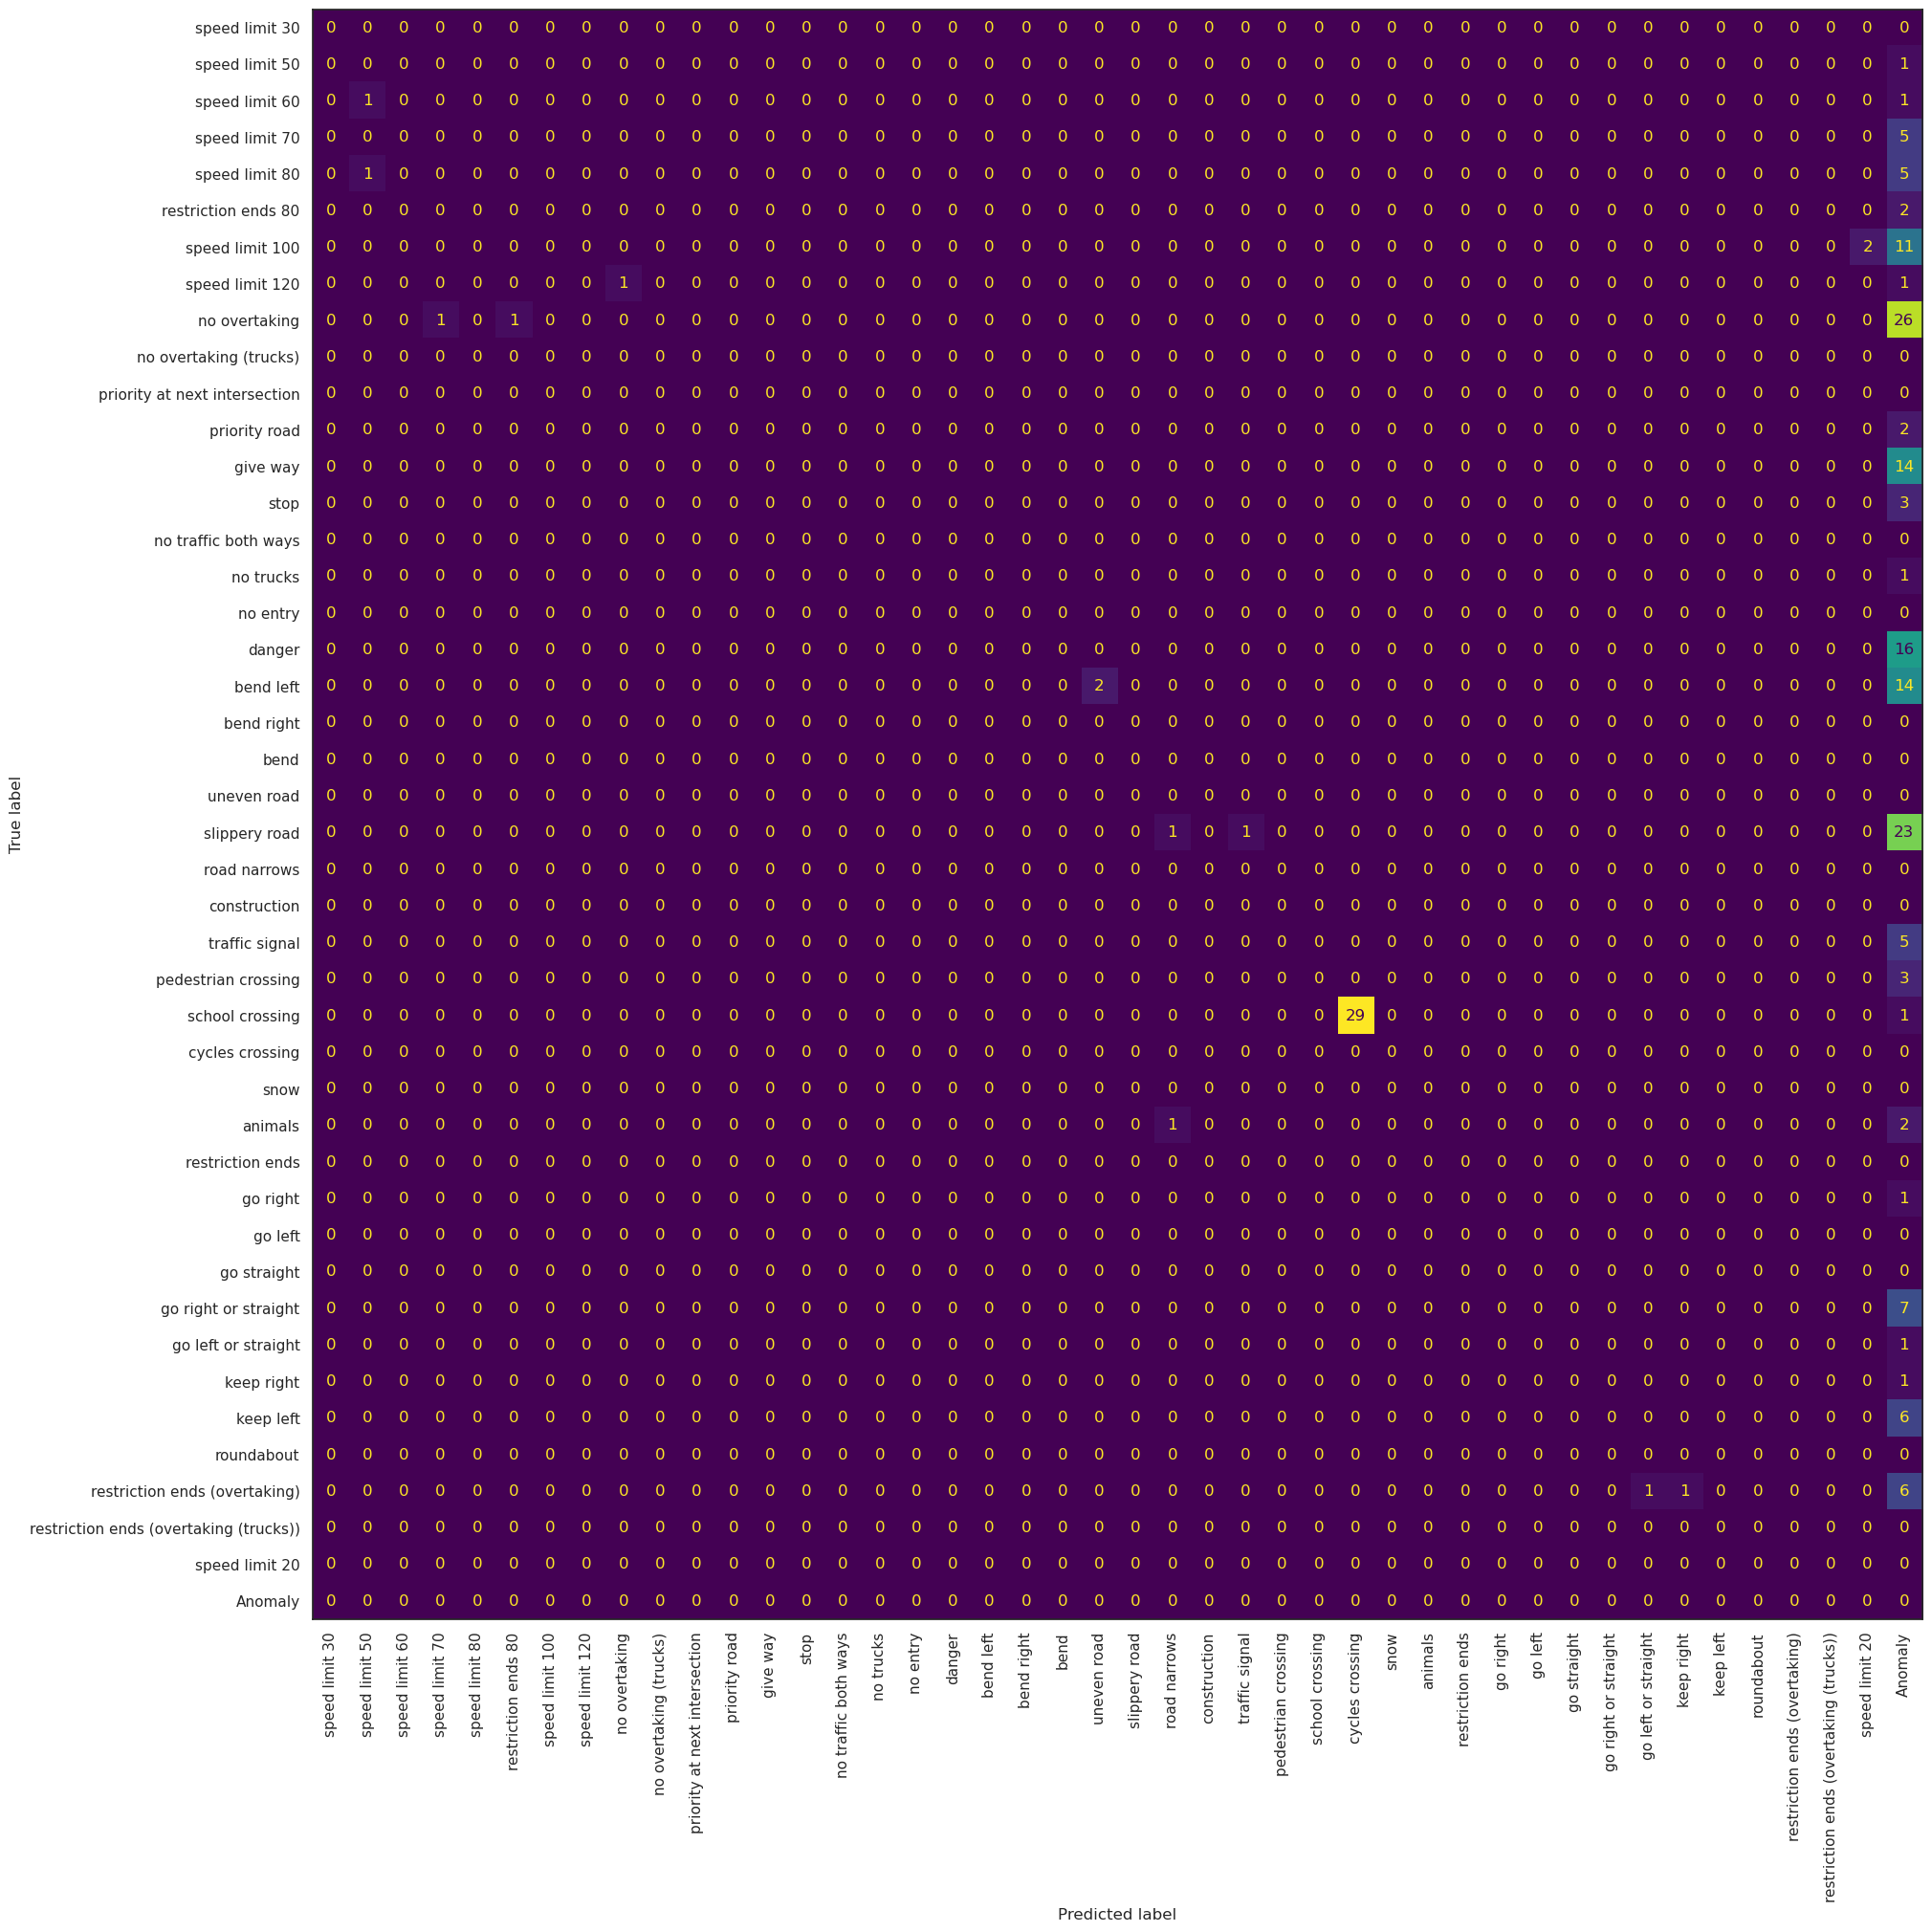

In [57]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sb 

ys_hat_anom = ys_hat.clone()
ys_hat_anom[my_scores > -0.99] = 44 

fig, ax = plt.subplots(figsize=(20,20))
m = confusion_matrix(ys[ys >= 0], ys_hat_anom[ys >= 0])

for i in range(m.shape[0]):
    m[i,i] = 0
    
disp = ConfusionMatrixDisplay(m, display_labels=list(dataset.class_to_name.values()) + ["Anomaly"])
disp.plot(ax=ax, xticks_rotation="vertical", colorbar=False)

plt.tight_layout(pad=0)

plt.savefig("img/confusion.pdf")
plt.savefig("img/confusion.jpg", dpi=300, bbox_inches="tight")

In [71]:
min_score = my_scores[ys < 0][my_scores[ys < 0] != -1].min().item() + 0.00001

ys_hat_anom = ys_hat.clone()
ys_hat_anom[my_scores > min_score] = -1 

(ys_hat_anom[ys >= 0] == 44).sum()

print(f"Total number of street signs {(ys >= 0).sum()}")
print(f"Total number of anomalies {(ys < 0).sum()}")
print(f"Signs mistakenly marked as anomalies (no matter prediction) {(ys_hat_anom[ys >= 0] < 0).sum()}")
print(f"Signs mistakenly marked as anomalies (correct sign predicted) {(ys_hat_anom[ys == ys_hat] < 0).sum()}")
print(f"Signs mistakenly marked as anomalies (false sign predicted) {(ys_hat_anom[(ys != ys_hat) & (ys >= 0)] < 0).sum()}")

print(f"Signs maked as non-anomalous (false sign predicted) {(  (ys_hat_anom >= 0) & (ys_hat_anom != ys) ).sum() }")
print(f"Anomaly mistakenly marked as sign (no matter prediction) {(ys_hat_anom[ys < 0] >= 0).sum()}")

t = (ys_hat_anom[ys == ys_hat] < 0).sum() + ((ys_hat_anom >= 0) & (ys_hat_anom != ys)).sum() + (ys_hat_anom[ys < 0] >= 0).sum()
total = ys.shape[0]
print(f"Instances where our decision was not optimal: {t}/{total}={t/total:.3%}")

Total number of street signs 12630
Total number of anomalies 45640
Signs mistakenly marked as anomalies (no matter prediction) 355
Signs mistakenly marked as anomalies (correct sign predicted) 256
Signs mistakenly marked as anomalies (false sign predicted) 99
Signs maked as non-anomalous (false sign predicted) 5
Anomaly mistakenly marked as sign (no matter prediction) 1
Instances where our decision was not optimal: 262/58270=0.450%


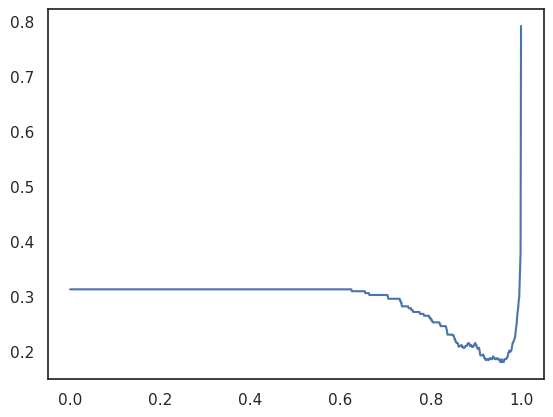

In [105]:
rs = []
xs = np.linspace(-0.0005, 0.999, 1000)
xss = []

for t in xs:
    min_score = my_scores[ys < 0][my_scores[ys < 0] != -1].min().item() + t
    xss.append(min_score * -1)
    ys_hat_anom = ys_hat.clone()
    ys_hat_anom[my_scores > min_score] = -1 
    r = (ys_hat_anom[ys == ys_hat] < 0).sum() + ((ys_hat_anom >= 0) & (ys_hat_anom != ys)).sum() + (ys_hat_anom[ys < 0] >= 0).sum()
    rs.append(r /ys.shape[0] * 100) #
    
plt.plot(xss, rs)

In [59]:
red_classes = [k for k, v in dataset.class_to_color.items() if dataset.color_to_name[v] == "red"]
red_classes.sort()
# red_classes

<AxesSubplot: xlabel='Scores', ylabel='Probability'>

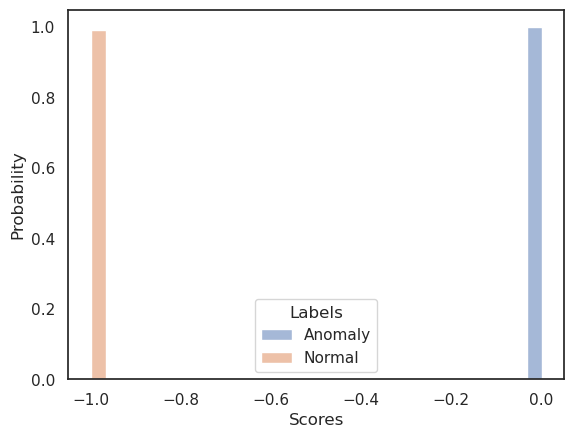

In [62]:
df_2 = DataFrame()
df_2["Scores"] = my_scores.cpu().numpy()
df_2["Labels"] = ys >= 0
df_2["Labels"] = df_2["Labels"].apply(ood_label)
df_2["Method"] = "Explicit"

sb.histplot(data=df_2, x="Scores", hue="Labels", common_norm=False, stat="probability", bins=30)

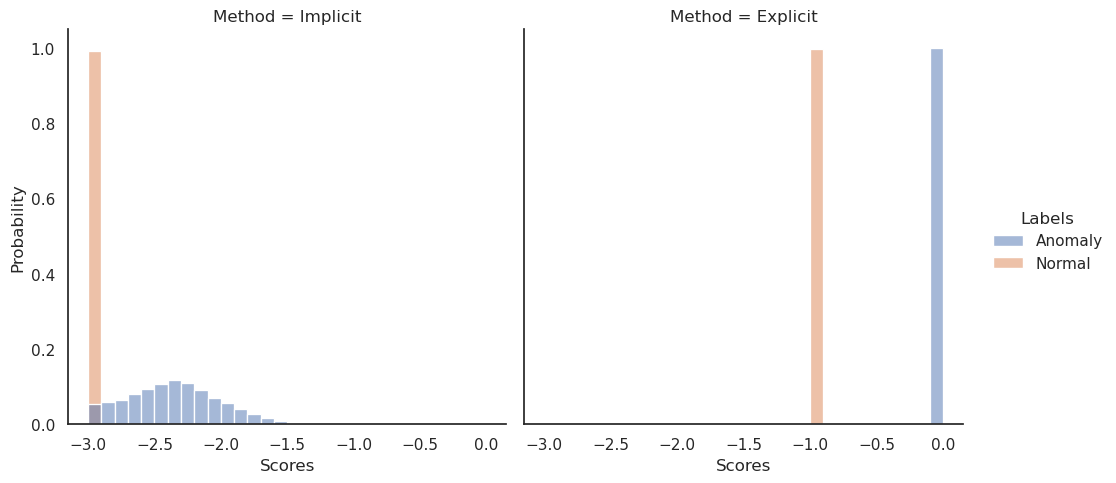

In [63]:
sb.displot(pd.concat([df_1, df_2]).reset_index(), x="Scores", hue="Labels", col="Method", stat="probability", bins=30, kind="hist",  common_norm=False)